# **Concentration Tracker for Hillslope Diffusion**
Written by: Laurent Roberge

Last edited: Sept. 23, 2024

## Purpose
This notebook is the User Manual for the hillslope concentration tracker described in Roberge et al., (2025). This notebook contains the code to reproduce the hillslope examples shown in Roberge et al, (202X) with necessary comments and directions so that users may adapt these examples for their own experimentation.

## Introduction
In this notebook, we introduce the ``ConcentrationTrackerForDiffusion`` Landlab component. This is a companion component to the ``DepthDependentDiffuser`` and ``TaylorDepthDependentDiffuser``. Both diffusion components simulate hillslope sediment transport by diffusive processes. ``ConcentrationTrackerForDiffusion`` uses the sediment fluxes from either component to calculate a mass balance and redistribute sediment tracer concentrations across a Landlab grid.

We walk through two examples of the ``ConcentrationTrackerForDiffusion``: first, a 1-dimensional hillslope cross-section that shows a pulse of tracer sediment that is transported downslope, then a 2-dimensional hillslope that shows how diffusional transport affects the surface expression of different coloured bands of bedrock as they are weathered and generate a mobile veneer of regolith.

## Background

There are two Landlab model components that simulate hillslope transport processes acting on a mobile regolith layer overlying bedrock: ``DepthDependentDiffuser`` and ``DepthDependentTaylorDiffuser`` (see depth-dependent creep laws in Barnhart et al., 2019). We refer the reader to Johnstone and Hilley (2014) and Ganti et al. (2012) for more information on the development of the diffusion equations that are contained in ``DepthDependentDiffuser`` and ``DepthDependentTaylorDiffuser``. Both components require a ‘soil production rate’, which can be provided in several different ways . Here, use the ``ExponentialWeatherer`` component, which implements an exponential soil production function in the style of Ahnert (1976).

The ``ConcentrationTracker`` uses a mass balance foundation and couples with these two hillslope transport components. We refer the reader to Roberge et al. (2025) for the details on the numerical implementation and coupling of the ``ConcentrationTracker`` with either ``DepthDependentDiffuser`` or ``DepthDependentTaylorDiffuser``.

## Running the code
First we import the required Python and Landlab libraries.

In [1]:
# Import mathematical libraries
import time
import numpy as np

# Import plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Import Landlab libraries
from landlab import RasterModelGrid, imshowhs_grid, NodeStatus
from landlab.components import (ExponentialWeatherer,
                                DepthDependentDiffuser,
                                ConcentrationTrackerForDiffusion,
                                )

In [2]:
# This allows plots show up in the notebook
%matplotlib inline

### 1-dimensional example
We begin with a 1-dimensional hillslope example that shows the movement of a pulse of tracer sediment as it travels downslope due to diffusive transport processes. This example is illustrated in Section 3 and Figure 3 of Roberge et al. (2025).

### Define input parameters 
Below, we define the input parameters that govern the size of the model grid and the timescale over which the model runs.
We also define the parameters governing the three Landlab model components that make up the model (the ``ExponentialWeatherer``, ``DepthDependentDiffuser``, and ``ConcentrationTrackerForDiffusion``). Finally, we define the uplift rate, which governs the steady-state erosion rate and therefore how tall and steep our hillslope will become.

In [3]:
# Grid parameters
nrows = 3
ncols = 22
dx = 10                # metres
dy = dx                # metres

# Time parameters
dt = 1                 # years
total_t = 200000       # years
print_interval = 2000  # years

# DepthDependentDiffuser parameters
D = 0.5                # m^2/yr
H_star = 1             # m
# NOTE: a diffusivity (D) value of 1 m^2/yr will reproduce the example shown in Figure __a of Roberge et al., 202X.
# Changing diffusivity to 0.5 m^2/yr and re-running the code will reproduce the example shown in Figure __b.

# ExponentialWeatherer parameters
P_0 = 0.01             # m/yr
H_s = 1                # m
# NOTE: a maximum soil production rate (P_0) value of 0.01 m/yr will reproduce the example shown in Figure __a of Roberge et al., 202X.
# Changing the value to 0.02 m/yr and re-running the code will reproduce the example shown in Figure __c.

# ConcentrationTracker parameters
# No parameters necessary for the moment

# Rock uplift rate that drives hillslope erosion 
uplift_rate = 0.001    # m/yr

# Some additional definitions and calculations
# -----------------------------------------------------------------------------
uplift_per_step = uplift_rate*dt
slope_toe_node = ncols
node_next_to_toe = ncols+1
ndt = int(total_t // dt)
years_elapsed = 0
# -----------------------------------------------------------------------------

### Generating the model grid and fields
Here, we generate a model grid that uses the grid parameters we defined above. In this case, we have a grid that is 3 rows tall and 20 columns long. The top and bottom rows are made up of boundary nodes, as are the left and right columns. We will close all of these (i.e., not allow flux across them), then open up only the leftmost node so that sediment can flux out of the domain. The leftmost node will be the bottom of the hillslope. Since the top and bottom rows are closed, we have a single middle row on which hillslope processes operate. This way, we generate a "1-dimensional" hillslope profile on a 2-dimensional grid.

We then add grid fields to store the data required to run the numerical model. We generate grid fields for soil depth, bedrock elevation, topographic elevation, and two concentration fields: one for concentration in sediment and another for concentration in bedrock. Concentrations are unit agnostic and can be defined by the user as any mass concentration (e.g., $kg/m^3$) or mass-like concentration (e.g., for a cosmogenic nuclide of interest: $atoms/grain$). In the examples below, we assume all material has the same density and differs only in colour. Therefore, the tracer sediment "concentration" values can be thought of as a mass fraction.

In [4]:
# %% Generate model grid
mg = RasterModelGrid((nrows, ncols), dx)
mg.axis_units = ('m', 'm')

# Set boundary conditions
mg.set_status_at_node_on_edges(right=NodeStatus.CLOSED,
                               top=NodeStatus.CLOSED,
                               left=NodeStatus.CLOSED,
                               bottom=NodeStatus.CLOSED)
mg.status_at_node[slope_toe_node] = NodeStatus.FIXED_VALUE

# Add fields (soil depth, bedrock elevation, topographic elevation)
h_soil = mg.add_zeros('soil__depth', at='node', units= ['m','m'])
elev_br = mg.add_zeros('bedrock__elevation', at='node', units= ['m','m'])
elev_topo = mg.add_zeros('topographic__elevation', at='node', units= ['m','m'])
mg.at_node['topographic__elevation'][:] += mg.at_node['bedrock__elevation']
mg.at_node['topographic__elevation'][:] += mg.at_node['soil__depth']

# Add concentration fields
C_soil = mg.add_zeros('sediment_property__concentration', at='node', units='kg/m^3')
C_br = mg.add_zeros('bedrock_property__concentration', at='node', units='kg/m^3')

# Some additional definitions for later visualization
# -----------------------------------------------------------------------------
core_ids = np.append(slope_toe_node, mg.core_nodes)
nframes = 1+ (total_t // print_interval)
nframe = 0
distance = mg.node_x[core_ids]
soil_elevs = np.zeros([nframes,len(core_ids)])
br_elevs = np.zeros([nframes,len(core_ids)])
C_values = np.zeros([nframes,len(core_ids)])
soil_elevs[nframe,:] = elev_topo[core_ids]
br_elevs[nframe,:] = elev_br[core_ids]
C_values[nframe,:] = C_soil[core_ids]
# -----------------------------------------------------------------------------

### Instantiating model components
Here, we instantiate three model components using the parameters defined at the beginning of the script. The ``ExponentialWeatherer`` solves for soil production rate (or conversion of bedrock to mobile regolith), the ``DepthDependentDiffuser`` solves for sediment fluxes and changes in soil depth from sediment transport, and the ``ConcentrationTrackerForDiffusion`` solves for the concentration of our tracer property in the "soil" or mobile regolith layer. These calculations will be made each timestep using the input parameters.

In [5]:
# %% Instantiate model components
ew = ExponentialWeatherer(mg,
                          soil_production_maximum_rate=P_0,
                          soil_production_decay_depth=H_s)

ddd = DepthDependentDiffuser(mg,
                             linear_diffusivity=D,
                             soil_transport_decay_depth=H_star)

ct = ConcentrationTrackerForDiffusion(mg)

### Visualization
Here, we generate an empty plot onto which we will render an animation of the 1-dimensional hillslope profile as it evolves through time.

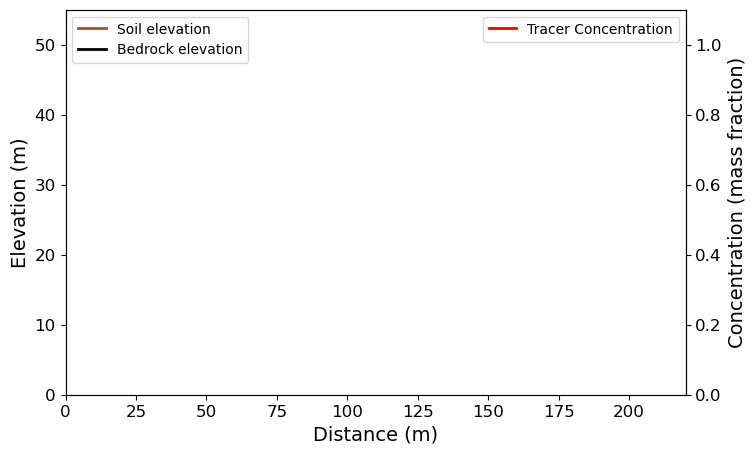

In [6]:
# Set up a background frame for plotting
ymax = 55  # Maximum y-axis value for elevation profile
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Create a figure and axes
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot()
ax2 = ax1.twinx()

# Set up the axes 
ax1.set_xlabel('Distance (m)', fontsize=14, color='black')
ax1.set_ylabel('Elevation (m)', fontsize=14, color='black')
ax1.set_xlim((0,ncols*dx))           
ax1.set_ylim((0,ymax))
ax1.tick_params(axis='y', labelcolor='black')
ax2.set_ylabel('Concentration (mass fraction)', fontsize=14, color='black')
ax2.set_ylim((0,1.1))
ax2.tick_params(axis='y', labelcolor='black')    

# Create empty objects for parts of the plot that will change in the animation. 
# They will be given new values for each frame.
txt_title = ax1.set_title('')
soil_elev_line, = ax1.plot([], [], 'sienna', lw=2)
bedrock_elev_line, = ax1.plot([], [], 'k', lw=2)
concentration_line, = ax2.plot([], [], 'r', lw=2)

ax1.legend(['Soil elevation','Bedrock elevation'],loc="upper left")
ax2.legend(['Tracer Concentration'],loc="upper right")

# Define animation function to be called sequentially to make an animation showing changes over time.
def drawframe(n):
    soil_elev_line.set_data(distance,soil_elevs[n,:])
    bedrock_elev_line.set_data(distance,br_elevs[n,:])
    concentration_line.set_data(distance,C_values[n,:])
    txt_title.set_text("Years elapsed: " + str(n*print_interval))
    return (soil_elev_line,bedrock_elev_line,concentration_line,txt_title)


### Running the numerical model loop
We will run the model for 200,000 years to generate a steady state hillslope profile in which soil depth and hillslope form are not changing in time. Within each iteration of the model loop, we first add rock uplift by increasing the elevation of the bedrock. Then, we ensure that topographic elevation (soil surface, or bedrock elevation plus soil depth) matches this change. Then, we run the ``ExponentialWeatherer`` and the ``DepthDependentDiffuser`` for one timestep. For this set-up period there is no need to track concentrations, so we don't run the ``ConcentrationTrackerForDiffusion``. Finally, we print the model progress and an estimate of the remaining runtime. This model run should take less than a minute.

In [7]:
# %% Run model to equilibrium
# Set initial timestamp (used to print progress updates)
start_time = time.time()

for i in range(ndt+1):
    # Add uplift, update topographic elevation to match bedrock and soil depths
    mg.at_node['bedrock__elevation'][mg.core_nodes] += uplift_per_step
    mg.at_node['topographic__elevation'][:] = (mg.at_node["bedrock__elevation"]
                                               + mg.at_node["soil__depth"])
    
    # Run ExponentialWeatherer and DepthDependentDiffuser
    ew.run_one_step()
    ddd.run_one_step(dt)

    # The model has now finished one iteration (i.e., acted over one timestep). 
    # Nothing below is required for the model to function. It is just used to print progress and save data for later visualization.
    # -----------------------------------------------------------------------------
    # Print progress
    current_time = time.time()
    years_elapsed = i*dt
    if i>0 and years_elapsed % print_interval == 0:
        runtime_remaining = (ndt-i)*(current_time - start_time)/i
        runtime_remaining_mins = round(runtime_remaining/60,2)
        print("Years elapsed:", round(years_elapsed/1000),
              "ka (", round(years_elapsed*100/total_t,2), "%)     ",
              "Runtime remaining:", runtime_remaining_mins, "min  ", end='\r')
        # Save data for plotting
        nframe += 1
        soil_elevs[nframe,:] = elev_topo[core_ids]
        br_elevs[nframe,:] = elev_br[core_ids]
        C_values[nframe,:] = C_soil[core_ids]
    # -----------------------------------------------------------------------------

### Plot the hillslope profile
Below, we plot the hillslope profile using our plotting function. The left y-axis shows elevation. There is a bedrock hillslope approximately 35 m tall (black line) covered by a mobile regolith layer several metres deep (brown line). The right y-axis shows our tracer concentration in this mobile regolith layer. Since we haven't added any tracer yet, it is zero throughout the profile.

In [8]:
# Plot the hillslope profile (this may take a minute to render)
anim = animation.FuncAnimation(fig, drawframe, frames=nframes, interval=100, repeat=False, blit=True)
HTML(anim.to_html5_video())

### Running the model with a spike of tracer concentration
Now, we add a spike of concentration to act as a tracer. We will change the ``sediment_property__concentration`` value from 0 to 1 at the 150 m mark (node #37).

In [10]:
# Add tracer to node #37
mg.at_node['sediment_property__concentration'][:] = 0    # Think of this as a mass fraction (here, there is no tracer sediment)
mg.at_node['sediment_property__concentration'][37] = 1   # Think of this as a mass fraction (here, all the sediment is tracer sediment)

# Set up new time parameters for this run
total_t = 10000        # years
print_interval = 10    # years

# Some additional definitions for later visualization
# -----------------------------------------------------------------------------
years_elapsed = 0
ndt = int(total_t // dt)

# For later visualization:
nframes = 1 + (total_t // print_interval)
nframe = 0
soil_elevs = np.zeros([nframes,len(core_ids)])
br_elevs = np.zeros([nframes,len(core_ids)])
C_values = np.zeros([nframes,len(core_ids)])
C_at_slope_toe = np.zeros([nframes])
soil_elevs[nframe,:] = elev_topo[core_ids]
br_elevs[nframe,:] = elev_br[core_ids]
C_values[nframe,:] = C_soil[core_ids]
C_at_slope_toe[nframe] = C_soil[node_next_to_toe]
# -----------------------------------------------------------------------------

We shorten the total runtime to 10,000 years to see the downslope movement of the tracer over that time period. Note that the ``ConcentrationTracker`` components do not use the typical Landlab run method of ``run_one_step(dt)``. Instead, the ``start_tracking()`` and ``stop_tracking(dt)`` methods are used before and after the flux component so that the ``ConcentrationTracker`` only tracks changes caused by that one instance of landscape change. This becomes very important when coupling multiple flux components to generate complex landscapes with many processes acting on them.

In [11]:
# Set initial timestamp (used to print progress updates)
start_time = time.time()

for i in range(ndt+1):
    # Add uplift, update topographic elevation to match bedrock and soil depths
    mg.at_node['bedrock__elevation'][mg.core_nodes] += uplift_per_step
    mg.at_node['topographic__elevation'][:] = (mg.at_node["bedrock__elevation"]
                                               + mg.at_node["soil__depth"])
    
    # Run ExponentialWeatherer, DepthDependentDiffuser, and ConcentrationTrackerForDiffusion
    ew.run_one_step()
    ct.start_tracking()
    ddd.run_one_step(dt)
    ct.stop_tracking(dt)

    # Print progress and save data for later visualization:
    # -----------------------------------------------------------------------------
    current_time = time.time()
    years_elapsed = i*dt
    if i>0 and years_elapsed % print_interval == 0:
        runtime_remaining = (ndt-i)*(current_time - start_time)/i
        runtime_remaining_mins = round(runtime_remaining/60,2)
        print("Years elapsed: ", years_elapsed,
              " (", round(years_elapsed*100/total_t,2), "%)",
              "   Runtime remaining: ", runtime_remaining_mins, " min   ", end='\r')
        # Save data for plotting
        nframe += 1
        soil_elevs[nframe,:] = elev_topo[core_ids]
        br_elevs[nframe,:] = elev_br[core_ids]
        C_values[nframe,:] = C_soil[core_ids]
        C_at_slope_toe[nframe] = C_soil[node_next_to_toe]
    # -----------------------------------------------------------------------------

### Plot the hillslope profile over time

Below, we see a gif of the hillslope profile as it changes through the first 5,000 years of the model run. The tracer concentration in the mobile regolith layer is depicted as a red line with values corresponding to the right y-axis. It starts as a spike near the top of the hillslope. The concentration spike quickly diminishes as regolith travels downslope. This animation shows that although the hillslope profile is at equilibrium and there is no net change to regolith depth or topography through time, the mobile regolith layer is actively mixing and moving downslope, while being replenished by bedrock weathering. 

Several frames from this animation are used to make Figure 3 of Roberge et al. (2025).

In [12]:
# Render and display the animation (this may take a minute to render)
C_values[:,0] = np.nan
anim = animation.FuncAnimation(fig, drawframe, frames=501, interval=40, repeat=False, blit=True)
HTML(anim.to_html5_video())

### Plot the concentration at the toe of the hillslope over time
We cut off the animation above at 5,000 years so that the rendering doesn't take too long. Below is a timeseries of the concentration that leaves the domain at the toe of the hillslope for the duration of the 10,000 year model run. The concentration values begin to rise after around 1,000 years as the tracer pulse reaches the toe of the slope. By 3,000 years, the peak of the pulse has passed and concentration values decrease until they approach zero again by 8,000 years or so. This is used in Figure 3 of Roberge et al. (2025).

Running the model again up to this point with a smaller diffusivity value, $D$, will produce a taller and steeper hillslope in order to generate the same sediment flux rate (equal to the rock uplift rate) while offsetting the decreased diffusivity. This will also result in a deeper soil layer. The tracer pulse will take longer to arrive at the toe of the slope, will reach its peak later, and will return to zero more slowly. This is due not to any change in flux rates, but to the ratio of flux rate to soil depth. Since the soil layer is deeper, the same flux rate translates to a smaller mixing ratio.

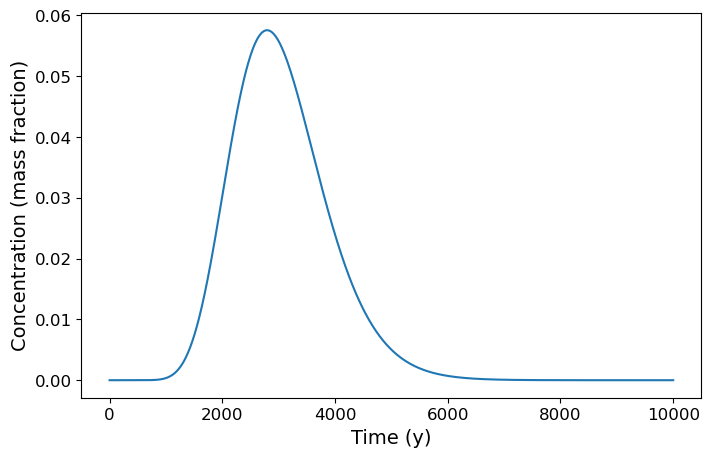

In [13]:
fig = plt.figure(figsize=(8,5))
ax = plt.subplot()
plt.plot(np.array(range(nframes))*print_interval,C_at_slope_toe)
ax.set_xlabel('Time (y)', fontsize=14, color='black')
ax.set_ylabel('Concentration (mass fraction)', fontsize=14, color='black')
plt.show()

### 2-dimensional example
Now, we show a 2-dimensional hillslope example in which the bedrock is composed of alternating horizontal bands of "red" and "white" coloured material. We use the ``bedrock_property__concentration`` and ``sediment_property__concentration`` to represent a fraction of red pigment in the bedrock and sediment. A value of 1 indicates 100% red material, while 0 indicates 0% red material. 

We will set up the hillslope to be very similar to the 1-dimensional example, except that the hilltop will be in the middle of the domain and fall away in all directions to create a hill. To do this, only the number of rows and columns need to change. We will also create an irregular shape of boundary grid nodes to demarcate the bottom of the hill.

This example is illustrated in Section 4 and Figure 5 of Roberge et al. (2025).

In [14]:
# New grid parameters
nrows = 41
ncols = 41

# Time parameters
total_t = 200000       # years
print_interval = 2000  # years

# Rock uplift rate that drives hillslope erosion 
uplift_rate = 0.002    # m/yr

# Some additional definitions and calculations
# -----------------------------------------------------------------------------
uplift_per_step = uplift_rate*dt
ndt = int(total_t // dt)
years_elapsed = 0
# -----------------------------------------------------------------------------

Instead of closing all but one side of the grid, we now create an odd shape of boundary grid nodes to demarcate the bottom of the hill. We chose the following list of grid nodes to close in order to create a hill shape that nicely depicts the processes at work.

In [15]:
hill_bottom_nodes = np.array([42,43,73,74,75,76,77,78,79,80,83,115,116,117,118,119,120,121,124,158,159,160,161,162,199,200,201,202,203,241,242,243,244,283,284,285,325,
                              326,366,367,407,408,449,490,531,1046,1047,1087,1088,1128,1129,1169,1187,1199,1209,1210,1228,1240,1250,1251,1269,1281,1291,1310,1322,1323,
                              1331,1332,1351,1363,1364,1372,1373,1392,1403,1404,1405,1413,1414,1432,1433,1444,1445,1446,1447,1454,1455,1473,1474,1477,1485,1486,1487,
                              1488,1494,1495,1496,1497,1514,1515,1518,1525,1526,1527,1528,1529,1530,1535,1536,1537,1538,1543,1544,1545,1546,1554,1555,1556,1559,1560,1565,
                              1566,1567,1568,1569,1570,1571,1572,1575,1576,1577,1578,1579,1580,1583,1584,1585,1586,1587,1588,1595,1596,1597,1600,1601,1602,1605,1606,1607,
                              1608,1609,1610,1611,1612,1613,1614,1615,1616,1617,1618,1619,1620,1621,1622,1623,1624,1625,1626,1627,1628,1629,1630,1631,1634,1635,1636,1637,1638,
                              ])

In [16]:
# %% Generate model grid
mg = RasterModelGrid((nrows, ncols), dx)
mg.axis_units = ('m', 'm')

# Set boundary conditions
mg.set_status_at_node_on_edges(right=mg.BC_NODE_IS_FIXED_VALUE,
                                 top=mg.BC_NODE_IS_FIXED_VALUE,
                                 left=mg.BC_NODE_IS_FIXED_VALUE,
                                 bottom=mg.BC_NODE_IS_FIXED_VALUE)
mg.status_at_node[hill_bottom_nodes] = NodeStatus.FIXED_VALUE

# Add fields (soil depth, bedrock elevation, topographic elevation)
h_soil = mg.add_zeros('soil__depth', at='node', units= ['m','m'])
elev_br = mg.add_zeros('bedrock__elevation', at='node', units= ['m','m'])
elev_topo = mg.add_zeros('topographic__elevation', at='node', units= ['m','m'])
mg.at_node['topographic__elevation'][:] += mg.at_node['bedrock__elevation']
mg.at_node['topographic__elevation'][:] += mg.at_node['soil__depth']

# Add concentration fields
C_soil = mg.add_zeros('sediment_property__concentration', at='node', units='kg/m^3')
C_br = mg.add_zeros('bedrock_property__concentration', at='node', units='kg/m^3')

# Some additional definitions for later visualization
# -----------------------------------------------------------------------------
x_section_ids = mg.nodes[15,:]
nframes = 1+ (total_t // print_interval)
nframe = 0
distance = mg.node_x[x_section_ids]
soil_elevs = np.zeros([nframes,len(x_section_ids)])
br_elevs = np.zeros([nframes,len(x_section_ids)])
C_values = np.zeros([nframes,len(x_section_ids)])
soil_elevs[nframe,:] = elev_topo[x_section_ids]
br_elevs[nframe,:] = elev_br[x_section_ids]
C_values[nframe,:] = C_soil[x_section_ids]
# -----------------------------------------------------------------------------

### Instantiating model components
We need to re-instantiate the model components for the new grid.

In [17]:
# %% Instantiate model components
ew = ExponentialWeatherer(mg,
                          soil_production_maximum_rate=P_0,
                          soil_production_decay_depth=H_s)

ddd = DepthDependentDiffuser(mg,
                             linear_diffusivity=D,
                             soil_transport_decay_depth=H_star)

ct = ConcentrationTrackerForDiffusion(mg)

### Running the numerical model loop
We will run the model for 200,000 years to generate a steady state hillslope profile. This model run should take a few minutes.

In [18]:
# %% Run model to equilibrium
# Set initial timestamp (used to print progress updates)
start_time = time.time()

for i in range(ndt+1):
    # Add uplift, update topographic elevation to match bedrock and soil depths
    mg.at_node['bedrock__elevation'][mg.core_nodes] += uplift_per_step
    mg.at_node['topographic__elevation'][:] = (mg.at_node["bedrock__elevation"]
                                               + mg.at_node["soil__depth"])
    
    # Run ExponentialWeatherer and DepthDependentDiffuser
    ew.run_one_step()
    ddd.run_one_step(dt)

    # Print progress and save data for later visualization:
    # -----------------------------------------------------------------------------
    current_time = time.time()
    years_elapsed = i*dt
    if i>0 and years_elapsed % print_interval == 0:
        runtime_remaining = (ndt-i)*(current_time - start_time)/i
        runtime_remaining_mins = round(runtime_remaining/60,2)
        print("Years elapsed:", round(years_elapsed/1000),
              "ka (", round(years_elapsed*100/total_t,2), "%)     ",
              "Runtime remaining:", runtime_remaining_mins, "min  ", end='\r')
        # Save data for plotting
        nframe += 1
        soil_elevs[nframe,:] = elev_topo[x_section_ids]
        br_elevs[nframe,:] = elev_br[x_section_ids]
        C_values[nframe,:] = C_soil[x_section_ids]
    # -----------------------------------------------------------------------------

### Plot a 2-dimensional hillshade plan view of the hillslope
Below we see a hillshade of the irregularly shaped hillslope.

<Axes: xlabel='Easting, m', ylabel='Northing, m'>

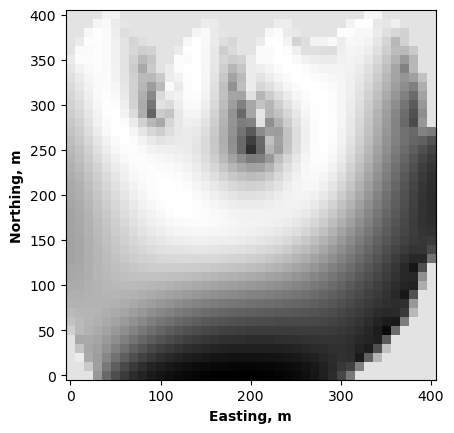

In [19]:
imshowhs_grid(mg, 'topographic__elevation', azdeg=215, plot_type='Hillshade')

### Plot a 1-dimensional hillslope cross-section
Here, we generate empty plots onto which we will render an animation of the 2-dimensional hillslope as it evolves through time after we add the bands of color. The animation will show a cross-sectional profile of the hillslope, similar to that of the 1-dimensional example.

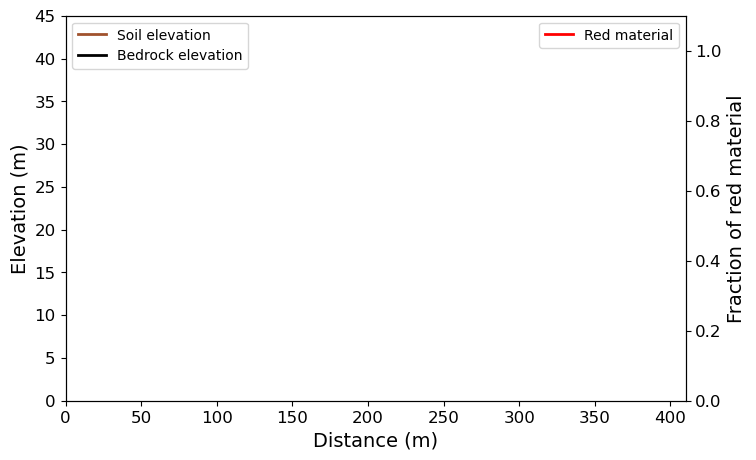

In [20]:
# Set up a background frame for plotting the cross-sectional profile
ymax = 45  # Maximum y-axis value for elevation profile
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Create a figure and axes
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot()
ax2 = ax1.twinx()

# Set up the axes 
ax1.set_xlabel('Distance (m)', fontsize=14, color='black')
ax1.set_ylabel('Elevation (m)', fontsize=14, color='black')
ax1.set_xlim((0,ncols*dx))           
ax1.set_ylim((0,ymax))
ax1.tick_params(axis='y', labelcolor='black')
ax2.set_ylabel('Fraction of red material', fontsize=14, color='black')
ax2.set_ylim((0,1.1))
ax2.tick_params(axis='y', labelcolor='black')    

# Create empty objects for parts of the plot that will change in the animation. 
# They will be given new values for each frame.
txt_title = ax1.set_title('')
soil_elev_line, = ax1.plot([], [], 'sienna', lw=2)
bedrock_elev_line, = ax1.plot([], [], 'k', lw=2)
concentration_line, = ax2.plot([], [], 'r', lw=2)

ax1.legend(['Soil elevation','Bedrock elevation'],loc="upper left")
ax2.legend(['Red material'],loc="upper right")

# Define animation function to be called sequentially to make an animation showing changes over time.
def draw_xs_frame(n):
    soil_elev_line.set_data(distance,soil_elevs[n,:])
    bedrock_elev_line.set_data(distance,br_elevs[n,:])
    concentration_line.set_data(distance,C_values[n,:])
    txt_title.set_text("Years elapsed: " + str(n*print_interval))
    return (soil_elev_line,bedrock_elev_line,concentration_line,txt_title)

In [21]:
# Plot the hillslope profile (this may take a minute to render)
anim = animation.FuncAnimation(fig, draw_xs_frame, frames=nframes, interval=100, repeat=False, blit=True)
HTML(anim.to_html5_video())

### Running the model with coloured bedrock layers
Now, we add a layer of different coloured bedrock by changing the colour concentration. We will change the ``bedrock_property__concentration`` value from 0 to 1 for all nodes that lie within two bedrock elevation bands: 10-14 m elevation and 23-26 m elevation. The plot below overlays the ``bedrock_property__concentration`` on top of the hillshade to clearly show the two bedrock layers. The mobile sediment layer (``bedrock_property__concentration``) has not been changed, so this figure only represents the bedrock layer underlying the mobile sediment. We will evolve the landscape by weathering bedrock and transporting the weathered material downslope. The ``ConcentrationTracker`` component calculates the concentration mass balance in both bedrock and sediment, so the surface sediment will gain colour as the coloured bedrock layers weather. This will allow us to see the surface expression of those buried layers.

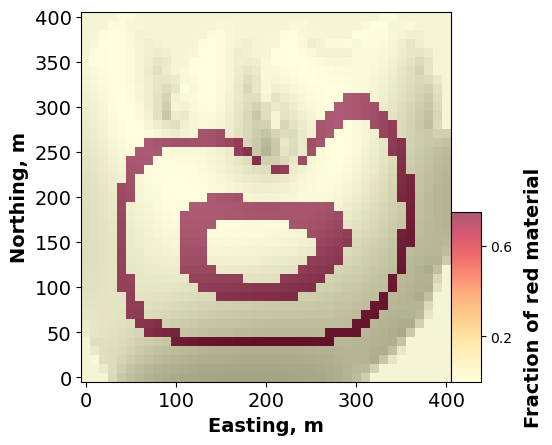

In [22]:
# Add colour to bands of bedrock
mg.at_node['sediment_property__concentration'][:] = 0
mg.at_node['bedrock_property__concentration'][:] = 0
mg.at_node['bedrock_property__concentration'][mg.at_node['bedrock__elevation']>14] = 1
mg.at_node['bedrock_property__concentration'][mg.at_node['bedrock__elevation']>18] = 0
mg.at_node['bedrock_property__concentration'][mg.at_node['bedrock__elevation']>31] = 1
mg.at_node['bedrock_property__concentration'][mg.at_node['bedrock__elevation']>35] = 0

# Visualize the hillshade with bedrock colour concentration overlain.
imshowhs_grid(mg, 'topographic__elevation', azdeg=215, cmap='YlOrRd',
              plot_type='Drape1', drape1="bedrock_property__concentration", default_fontsize=14,
              alpha=0.65, var_name='Fraction of red material', limits=(0,0.75),
              allow_colorbar=True, cbar_or='vertical', cbar_loc='lower right',
              bbox_to_anchor=(1.08,0), cbar_height=1.7, cbar_width=0.3, 
              colorbar_label_y=8, color_for_closed='pink',
              )
plt.show()

Here, we update a few parameters and then run the model loop.

In [23]:
# Set up new time parameters for this run
total_t = 10000       # years
print_interval = 10   # years

# Some additional definitions
# -----------------------------------------------------------------------------
years_elapsed = 0
ndt = int(total_t // dt)
nframes = 1 + (total_t // print_interval)
nframe = 0
soil_elevs = np.zeros([nframes,len(x_section_ids)])
br_elevs = np.zeros([nframes,len(x_section_ids)])
C_values = np.zeros([nframes,len(x_section_ids)])
soil_elevs[nframe,:] = elev_topo[x_section_ids]
br_elevs[nframe,:] = elev_br[x_section_ids]
C_values[nframe,:] = C_soil[x_section_ids]
# -----------------------------------------------------------------------------

In [24]:
# Run model
start_time = time.time()

for i in range(ndt+1):
    # Add uplift, update topographic elevation to match bedrock and soil depths
    mg.at_node['bedrock__elevation'][mg.core_nodes] += uplift_per_step
    mg.at_node['topographic__elevation'][:] = (mg.at_node["bedrock__elevation"]
                                               + mg.at_node["soil__depth"])
    
    # Run ExponentialWeatherer, DepthDependentDiffuser, and ConcentrationTrackerForDiffusion
    ew.run_one_step()
    ct.start_tracking()
    ddd.run_one_step(dt)
    ct.stop_tracking(dt)

    # Print progress and save data for later visualization:
    # -----------------------------------------------------------------------------
    current_time = time.time()
    years_elapsed = i*dt
    if i>0 and years_elapsed % print_interval == 0:
        runtime_remaining = (ndt-i)*(current_time - start_time)/i
        runtime_remaining_mins = round(runtime_remaining/60,2)
        print("Years elapsed: ", years_elapsed,
              " (", round(years_elapsed*100/total_t,2), "%)",
              "   Runtime remaining: ", runtime_remaining_mins, " min   ", end='\r')
        # Save data for plotting
        nframe += 1
        soil_elevs[nframe,:] = elev_topo[x_section_ids]
        br_elevs[nframe,:] = elev_br[x_section_ids]
        C_values[nframe,:] = C_soil[x_section_ids]
    # -----------------------------------------------------------------------------

Below, we visualize the bedrock colour and compare it to the mobile sediment colour, which is the surface expression of these two bedrock layers. The surface expression is spread out and muted due to the diffusional sediment transport processes that mix sediment as it moves downslope. The steep faces have fast transport rates that cause a lot of material to mix. Additionally, the concave areas tend to mix a lot due to the convergence of sediment fluxes from the surrounding slopes. On the other hand, the convex noses mix less. The shallow slope angle and the convex shape of the noses mean that little material is fluxed into these areas and material is mostly locally derived from the underlying bedrock.

These are used to make Figure 5 of Roberge et al. (2025).

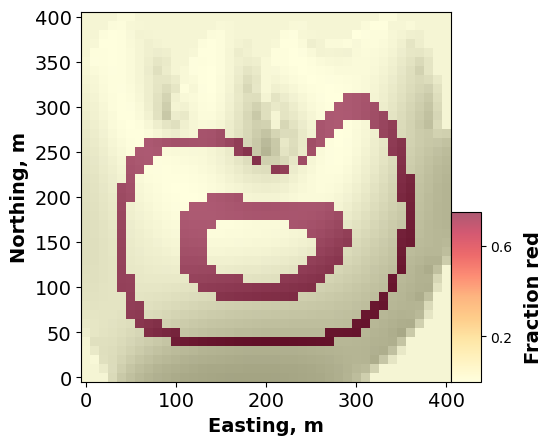

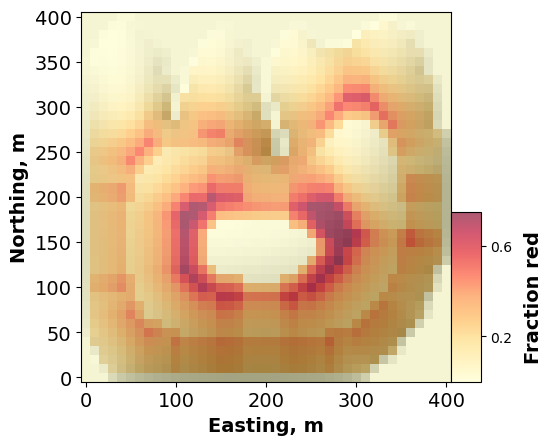

In [25]:
imshowhs_grid(mg, 'topographic__elevation', azdeg=215, cmap='YlOrRd',
              plot_type='Drape1', drape1="bedrock_property__concentration", default_fontsize=14,
              alpha=0.65, var_name='Fraction red', limits=(0,0.75),
              allow_colorbar=True, cbar_or='vertical', cbar_loc='lower right',
              bbox_to_anchor=(1.08,0), cbar_height=1.7, cbar_width=0.3, 
              colorbar_label_y=8, color_for_closed='pink',
              )
plt.show()

imshowhs_grid(mg, 'topographic__elevation', azdeg=215, cmap='YlOrRd',
              plot_type='Drape1', drape1="sediment_property__concentration", default_fontsize=14,
              alpha=0.65, var_name='Fraction red', limits=(0,0.75),
              allow_colorbar=True, cbar_or='vertical', cbar_loc='lower right',
              bbox_to_anchor=(1.08,0), cbar_height=1.7, cbar_width=0.3, 
              colorbar_label_y=8, color_for_closed='pink',
              )
plt.show()

### Plot the hillslope profile through time

Below, we see a gif of the hillslope profile from west to east at the 150 m mark. The gif shows changes through the first 3,000 years of the model run. The colour concentration in the mobile regolith layer is depicted as a red line with values corresponding to the right y-axis. The two coloured bedrock layers begin to weather immediately and add coloured sediment into the mobile layer, increasing the local concentration value. As the material is transported downslope, it mixes and the concentration decreases when it begins to mix with material weathering from un-coloured parent bedrock. This results in an increase in concentration over top of the coloured layers and a decrease over the un-coloured layers.

In [26]:
# Render and display the animation (this may take a minute to render)
C_values[:,(0,-1)] = np.nan
anim = animation.FuncAnimation(fig, drawframe, frames=301, interval=40, repeat=False, blit=True)
HTML(anim.to_html5_video())

### References

Ahnert, F. (1976). Brief description of a comprehensive three-dimensional process-response model of landform development Z. Geomorphol. Suppl. 25, 29 - 49.

Barnhart, K.R., Glade, R.C., Shobe, C.M., and Tucker, G.E. (2019). Terrainbento 1.0: a Python package for multi-model analysis in long-term drainage basin evolution. Geoscientific Model Development, 12, 1267 – 1297. https://doi.org/10.5194/gmd-12-1267-2019.

Ganti, V., Passalacqua, P., and Foufoula‐Georgiou, E.: A sub‐grid scale closure for nonlinear hillslope sediment transport models, J. Geophys. Res., 117, 2011JF002181, https://doi.org/10.1029/2011JF002181, 2012.

Johnstone, S.A. and Hilley, G.E.: Lithologic control on the form of soil-mantled hillslopes, Geology, 43, 83–86, https://doi.org/10.1130/G36052.1, 2015.

Roberge, L., Gasparini, N., Campforts, B., and Tucker., G. (2025). ____